In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor


columns = ["store_id", "job_id", "actual_start_time_picking", "actual_end_time_picking", "optimal_start_time_picking", "optimal_end_time_picking"]

df = pd.read_csv("data/bq-results-20240402-190356-1712084675776.csv")

df["actual_start_time_picking"] = pd.to_datetime(df["actual_start_time_picking"], format='%Y-%m-%d %H:%M:%S.%f UTC', errors='coerce')
df["actual_end_time_picking"] = pd.to_datetime(df["actual_end_time_picking"], format='%Y-%m-%d %H:%M:%S.%f UTC', errors='coerce')
df["optimal_start_time_picking"] = pd.to_datetime(df["optimal_start_time_picking"], format='%Y-%m-%d %H:%M:%S UTC', errors='coerce')
df["optimal_end_time_picking"] = pd.to_datetime(df["optimal_end_time_picking"], format='%Y-%m-%d %H:%M:%S UTC', errors='coerce')
df["actual_processing_time"] = df["actual_end_time_picking"] - df["actual_start_time_picking"]
df["optimal_processing_time"] = df["optimal_end_time_picking"] - df["optimal_start_time_picking"]
df["actual_processing_time_min"] = (df["actual_end_time_picking"] - df["actual_start_time_picking"]).dt.total_seconds() / 60
df["optimal_processing_time_min"] = (df["optimal_end_time_picking"] - df["optimal_start_time_picking"]).dt.total_seconds() / 60
df["delay_minutes"] = (df["actual_processing_time"] - df["optimal_processing_time"]).dt.total_seconds() / 60 
df.head(10)


,store_id,job_id,actual_start_time_picking,actual_end_time_picking,optimal_start_time_picking,optimal_end_time_picking,actual_processing_time,optimal_processing_time,actual_processing_time_min,optimal_processing_time_min,delay_minutes
0,732eec9f-fc84-4d20-86b9-fe357a0976bb,79a83c1b-59dd-412e-af07-5fda4a5bb261,2024-03-05 19:51:56.143,2024-03-05 19:52:12.299,2024-03-05 21:03:00,2024-03-05 21:08:00,0 days 00:00:16.156000,0 days 00:05:00,0.269267,5.0,-4.730733
1,115ee3df-80e2-4c17-a5e9-29bcae08fe01,c8b6daa6-63fa-4a7a-80ec-1980b9895fd4,2024-03-04 23:28:00.364,2024-03-04 23:52:55.154,2024-03-04 23:28:00,2024-03-04 23:32:00,0 days 00:24:54.790000,0 days 00:04:00,24.913167,4.0,20.913167
2,6a54da8e-9ba7-4f0a-a143-d7711eb6b5e7,ae98ef17-dd5d-4459-afb6-47631e6c64b9,2024-03-04 23:24:34.852,2024-03-05 03:14:43.896,2024-03-04 23:29:00,2024-03-05 00:08:00,0 days 03:50:09.044000,0 days 00:39:00,230.150733,39.0,191.150733
3,ab0c60c6-1935-4f1d-a80a-25d0e9e8fbb7,12dcc93b-da53-48f3-abb5-b2bfd873745b,2024-03-05 00:37:04.803,2024-03-05 00:57:51.608,2024-03-05 00:42:00,2024-03-05 00:45:00,0 days 00:20:46.805000,0 days 00:03:00,20.780083,3.0,17.780083
4,3f298c0f-d807-4d26-9908-8c3f3f2b369a,efae594a-3fdf-4e13-a71c-a53c7185888f,2024-03-05 00:59:40.621,2024-03-05 01:04:45.473,2024-03-05 01:04:00,2024-03-05 01:06:00,0 days 00:05:04.852000,0 days 00:02:00,5.080867,2.0,3.080867
5,b37369cc-9a55-4d73-9f62-a15892b4e3a1,a6b9da9d-b793-4b6f-9291-d3c1f03275e5,2024-03-05 21:24:47.037,2024-03-05 21:27:00.797,2024-03-06 01:17:00,2024-03-06 01:21:00,0 days 00:02:13.760000,0 days 00:04:00,2.229333,4.0,-1.770667
6,09c02529-8a8a-498b-8bcd-422a7f5cbe83,23b8ed26-6431-49e5-8a79-65f18b7a5bef,2024-03-05 01:23:35.785,2024-03-05 01:25:02.035,2024-03-05 01:23:00,2024-03-05 01:26:00,0 days 00:01:26.250000,0 days 00:03:00,1.437500,3.0,-1.562500
7,ab0c60c6-1935-4f1d-a80a-25d0e9e8fbb7,96494e68-2f52-4584-8571-5960581554b2,2024-03-05 15:36:38.695,2024-03-05 15:47:12.097,2024-03-05 15:36:00,2024-03-05 15:49:00,0 days 00:10:33.402000,0 days 00:13:00,10.556700,13.0,-2.443300
8,3f298c0f-d807-4d26-9908-8c3f3f2b369a,e5be8091-e995-4a30-9ee9-27b7fdbed8e1,2024-03-04 22:01:15.474,2024-03-04 22:09:54.515,2024-03-04 22:06:00,2024-03-04 22:08:00,0 days 00:08:39.041000,0 days 00:02:00,8.650683,2.0,6.650683
9,f6da8109-e12d-4565-832a-beca657b17d2,8cf251ea-c9ed-4b6a-8e09-dd326bf54448,2024-03-05 18:49:06.193,2024-03-05 18:49:53.721,2024-03-05 20:57:00,2024-03-05 21:01:00,0 days 00:00:47.528000,0 days 00:04:00,0.792133,4.0,-3.207867


In [234]:
Q1 = df['delay_minutes'].quantile(0.25)
Q3 = df['delay_minutes'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"IQR Lower bound {lower_bound} Upper bound {upper_bound}")

lower_bound = -1500
upper_bound = 1500

outliers = df[(df['delay_minutes'] < lower_bound) | (df['delay_minutes'] > upper_bound)]
print(f"Filtered percentage of data {100 - (len(outliers.index) / len(df.index))}")

print(f"Estimated Lower bound {lower_bound} Upper bound {upper_bound}")


IQR Lower bound -46.192029166666664 Upper bound 67.84347083333333
Filtered percentage of data 99.99950467444951
Estimated Lower bound -1500 Upper bound 1500


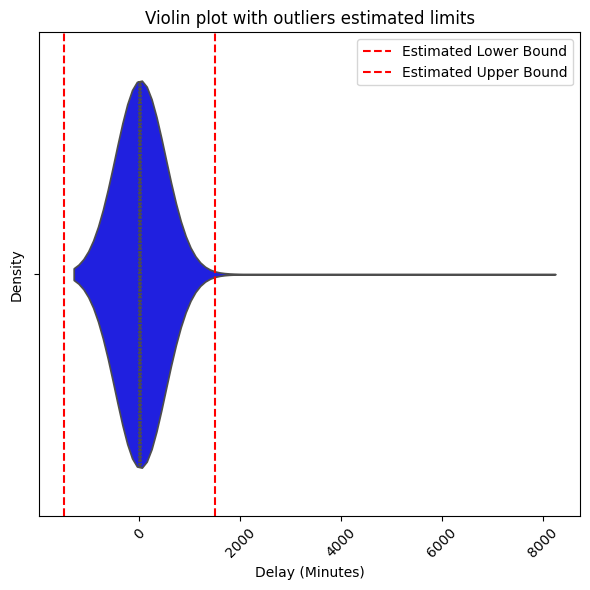

In [235]:
# Create violin plots with adjusted bandwidth
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(x=-1500, color='red', linestyle='dashed', label='Estimated Lower Bound')
ax.axvline(x=1500, color='red', linestyle='dashed', label='Estimated Upper Bound')
sns.violinplot(x="delay_minutes", data=df, inner="quartile", color="blue", bw_method=5.5)
plt.xlabel("Delay (Minutes)")
plt.ylabel("Density")
plt.title("Violin plot with outliers estimated limits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [236]:
dataset = outliers.copy()

dataset['month'] = dataset.actual_start_time_picking.dt.month
dataset['day_of_week'] = dataset.actual_start_time_picking.dt.dayofweek
dataset['year'] = dataset.actual_start_time_picking.dt.year

label_encoder = LabelEncoder()
dataset['store_id_encoded'] = label_encoder.fit_transform(dataset['store_id'])

features = dataset[['store_id_encoded', 'actual_processing_time_min', 'optimal_processing_time_min', 'year', 'month', 'day_of_week']]
target = dataset['delay_minutes']
features.head(5)



,store_id_encoded,actual_processing_time_min,optimal_processing_time_min,year,month,day_of_week
9728,34,2294.529733,3.0,2024,3,0
10266,51,2730.306683,3.0,2024,3,0
11739,71,1919.021017,60.0,2024,3,1
14080,65,2896.392617,26.0,2024,3,6
15341,47,1548.676950,3.0,2024,3,0


In [237]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
print("Feature Importance:")
for feature, importance in zip(features.columns, importances):
    print(f"{feature}: {importance:.4f}")

Feature Importance:
store_id_encoded: 0.0042
actual_processing_time_min: 0.9756
optimal_processing_time_min: 0.0053
year: 0.0149


In [238]:
features = dataset[['store_id_encoded', 'actual_processing_time_min', 'optimal_processing_time_min', 'day_of_week']]
features.head(5)

,store_id_encoded,actual_processing_time_min,optimal_processing_time_min,day_of_week
9728,34,2294.529733,3.0,0
10266,51,2730.306683,3.0,0
11739,71,1919.021017,60.0,1
14080,65,2896.392617,26.0,6
15341,47,1548.676950,3.0,0


In [239]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE calculation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.4f}")

Random Forest Evaluation Metrics:
MAE: 52.57
MAPE: 1.97%
MSE: 11440.51
R2: 0.9842


In [240]:
target = dataset['delay_minutes']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.4f}")

XGBoost Evaluation Metrics:
MAE: 34.20
MAPE: 1.22%
MSE: 4385.02
R2: 0.9939
